In [3]:
from fastai.vision.all import *
import warnings
from PIL import Image



In [4]:

path = untar_data(URLs.IMAGENETTE_160)

In [5]:
print(path)

/home/devcontainers/.fastai/data/imagenette2-160


In [6]:
dls = ImageDataLoaders.from_folder(
    path,
    valid='val', 
    item_tfms=RandomResizedCrop(128, min_scale=0.35), 
    batch_tfms=Normalize.from_stats(*imagenet_stats)
)

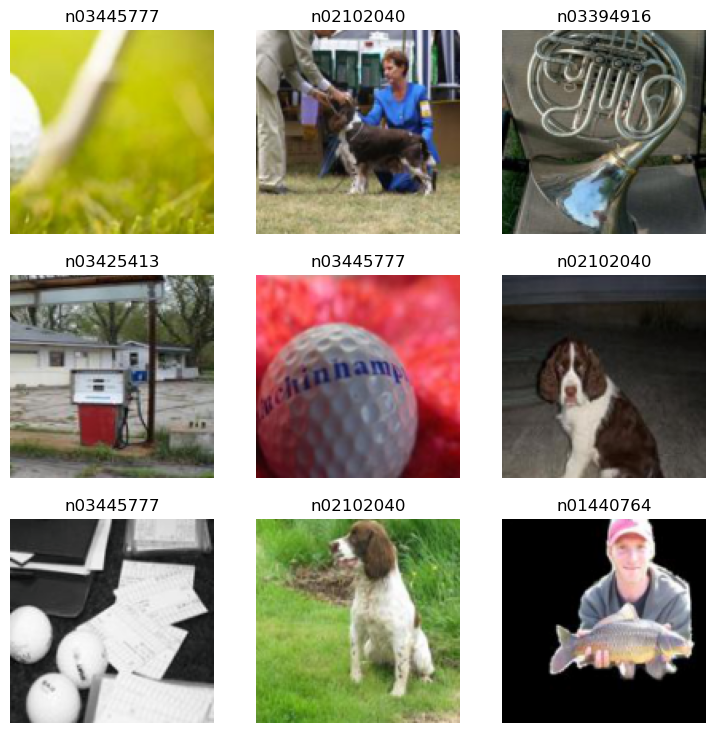

In [7]:
dls.show_batch()

In [8]:
fnames = get_image_files(path)

In [9]:
dblock = DataBlock()

In [10]:
dsets = dblock.datasets(fnames)
dsets.train[0]

(Path('/home/devcontainers/.fastai/data/imagenette2-160/val/n03000684/n03000684_17082.JPEG'),
 Path('/home/devcontainers/.fastai/data/imagenette2-160/val/n03000684/n03000684_17082.JPEG'))

In [11]:
dblock = DataBlock(get_items = get_image_files)

In [12]:
dsets = dblock.datasets(path)
dsets.train[0]

(Path('/home/devcontainers/.fastai/data/imagenette2-160/train/n03000684/n03000684_25155.JPEG'),
 Path('/home/devcontainers/.fastai/data/imagenette2-160/train/n03000684/n03000684_25155.JPEG'))

In [13]:
parent_label(fnames[0])

'n02979186'

In [14]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [15]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [16]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path)
dsets.train[0]

(Path('/home/devcontainers/.fastai/data/imagenette2-160/train/n03888257/n03888257_22053.JPEG'),
 'parachute')

In [17]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=160x213, TensorCategory(2))

In [18]:
dsets.vocab

['English springer', 'French horn', 'cassette player', 'chain saw', 'church', 'garbage truck', 'gas pump', 'golf ball', 'parachute', 'tench']

In [19]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter())

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=160x160, TensorCategory(2))

In [20]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter(),
                   item_tfms = RandomResizedCrop(128, min_scale=0.35), 
                   batch_tfms=Normalize.from_stats(*imagenet_stats))

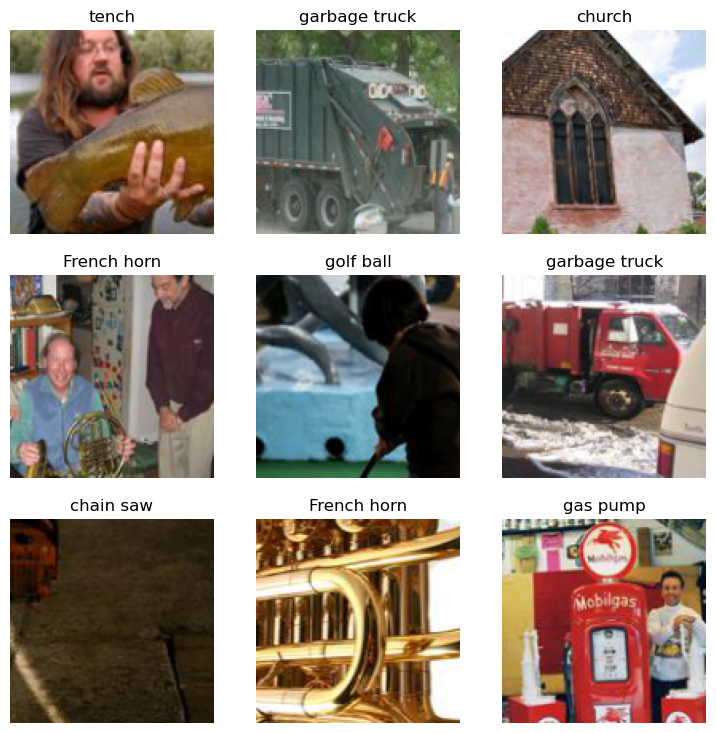

In [21]:
dls = dblock.dataloaders(path)
dls.show_batch()

In [22]:
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize.from_stats(*imagenet_stats))

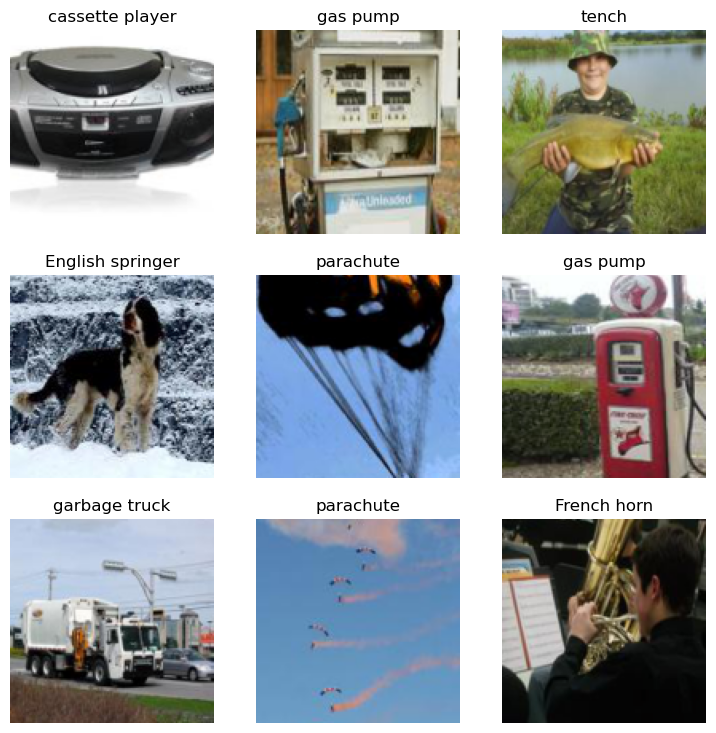

In [23]:
dls = imagenette.dataloaders(path)
dls.show_batch()

In [24]:
source = untar_data(URLs.IMAGENETTE_160)
fnames = get_image_files(source)

In [25]:
lbl_dict[parent_label(fnames[0])]

'cassette player'

In [26]:
tfm = Pipeline([parent_label, lbl_dict.__getitem__, Categorize(vocab = lbl_dict.values())])
tfm(fnames[0])

TensorCategory(2)

In [27]:
splits = GrandparentSplitter(valid_name='val')(fnames)

In [29]:
dsets = Datasets(fnames, [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize]], splits=splits)

In [30]:
dsets[0]

(PILImage mode=RGB size=213x160, TensorCategory(2))

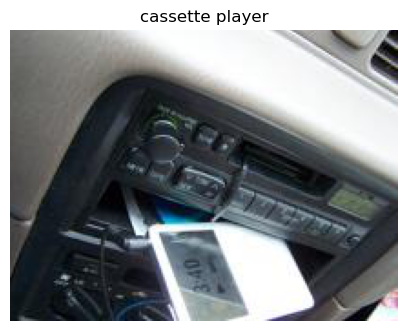

In [31]:
dsets.show(dsets[0]);

In [32]:
item_tfms = [ToTensor, RandomResizedCrop(128, min_scale=0.35)]

In [33]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]

In [34]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64, num_workers=8)

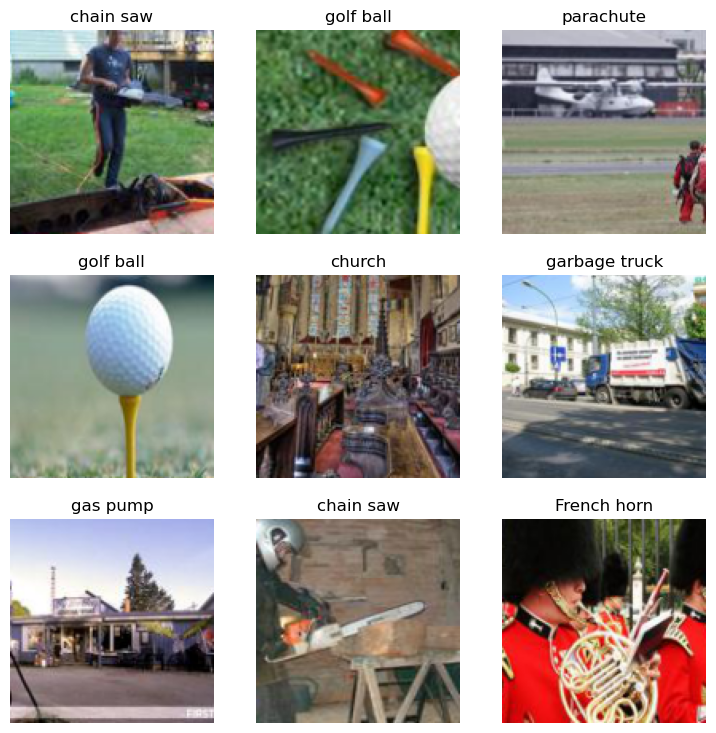

In [35]:
dls.show_batch()

In [36]:
learn = vision_learner(dls, resnet34, metrics=accuracy, pretrained=False)

In [37]:
learn.fit_one_cycle(5, 5e-3)

IOStream.flush timed out


In [38]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy)

/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locati

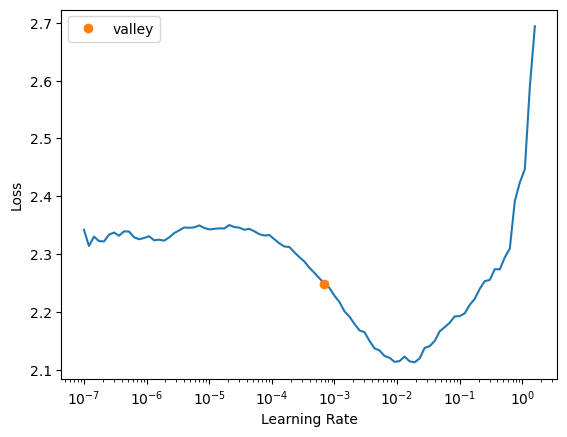

In [40]:
lr_valley = learn.lr_find()

In [41]:
learn.fit_one_cycle(5, lr_valley)

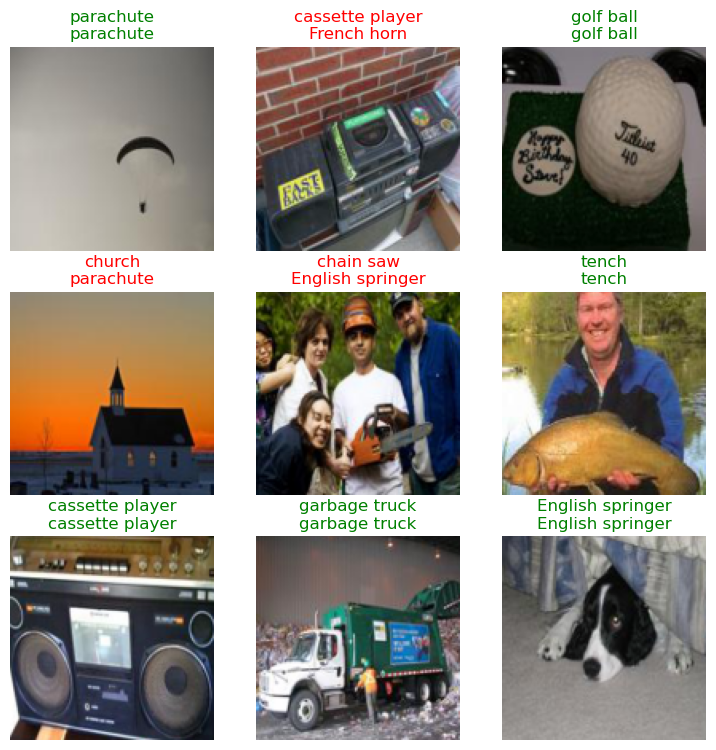

In [42]:
learn.show_results()

In [44]:
class LabelSmoothingCE(Module):
    def __init__(self, eps=0.1, reduction='mean'): 
        self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': 
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

In [45]:
learn = Learner(dls, xresnet34(n_out=10), loss_func=LabelSmoothingCE(), metrics=accuracy)

In [46]:
learn.fit_one_cycle(5, 1e-3)

In [47]:
learn.predict(fnames[0])

('cassette player',
 tensor(2),
 tensor([0.2427, 0.0961, 0.3015, 0.0649, 0.0535, 0.0635, 0.0254, 0.0542, 0.0283,
         0.0698]))

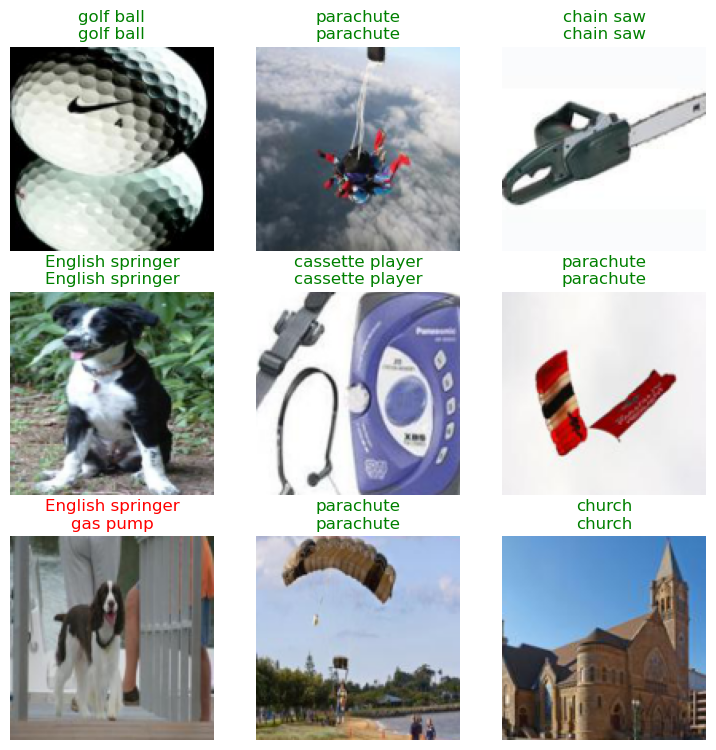

In [48]:
learn.show_results()

In [49]:
pytorch_adamw = partial(OptimWrapper, opt=torch.optim.AdamW)

In [50]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(pytorch_adamw, weight_decay=0.01, eps=1e-3))

/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locati

SuggestedLRs(valley=0.002511886414140463)

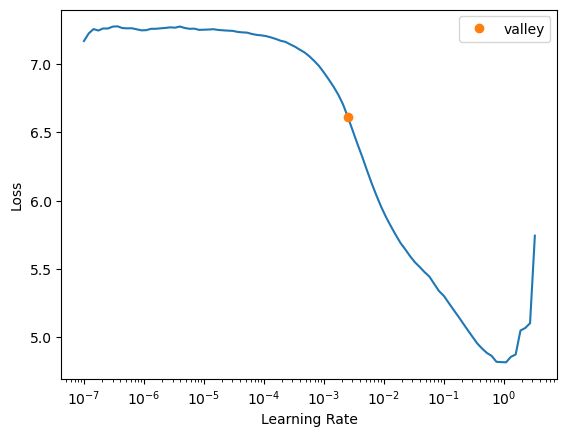

In [51]:
learn.lr_find()

In [52]:
learn.fit_one_cycle(5, 5e-3)

In [55]:
for xb,yb in dl:
    pred = model(xb)
    loss = loss_func(pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()

ValueError: too many values to unpack (expected 2)

In [57]:
from torch.distributions.beta import Beta

In [58]:
class Mixup(Callback):
    run_valid = False
    
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
    
    def before_batch(self):
        self.t = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        x1,self.y1 = self.x[shuffle],self.y[shuffle]
        self.learn.xb = (x1 * (1-self.t[:,None,None,None]) + self.x * self.t[:,None,None,None],)
    
    def after_loss(self):
        with NoneReduce(self.loss_func) as lf:
            loss = lf(self.pred,self.y1) * (1-self.t) + lf(self.pred,self.y) * self.t
        self.learn.loss = loss.mean()

In [59]:
learn = Learner(
    dls, 
    xresnet18(),
    lr=1e-2,
    metrics=accuracy,
    loss_func=LabelSmoothingCrossEntropy(), 
    cbs=Mixup(),
    opt_func=partial(pytorch_adamw, weight_decay=0.01, eps=1e-3)
)

/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locati

SuggestedLRs(valley=0.0020892962347716093)

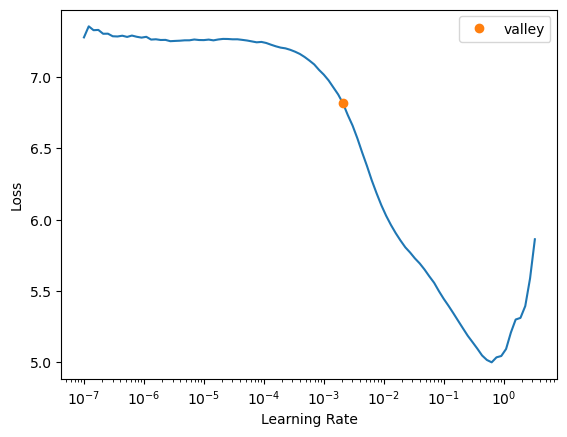

In [60]:
learn.lr_find()

In [61]:
learn.fit_one_cycle(5, 5e-3)